
# What Knitting Pattens are are the most popular?
## *An analysis of pattern data from Raverly.com*

This analysis uses data that I collected Ravelry.com via its API (see first ipynb file). Ravelry is an online community of knitters & crocheters - I have been a member since 2021. Most users use Ravelry to find designers and purchase patterns, get yarn inspiration, or make connections in the community.

It seems like the API was very open (via an API key) - with the ability to retreive a lot of different data type. While working on this project, I found another [analysis on github](https://github.com/tfwhitesell/ravelry_capstone/tree/master) of Ravelry data that was focused on the location of users vs. the location of yarn stores in the United States (to come up with recommended yarn store locations). This analysis was really interesting (and helpful), but I wanted to make sure I was looking at a different piece of the data.

One of my New Years resolutions this year was to actually create my own knitting pattern. I have not done it yet, so with a month left in 2023, I decided to focus on what types of patterns are the most popular on Ravelry.com to help inspire my pattern designs. Specifically, I want to answer the following questions:

1. What type of pattern should I design?
2. What needles size and/or yarn weight should it use?
3. How much should I charge for it?*italicized text*

In [1]:
import pandas as pd
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection
from matplotlib import pyplot as plt
import seaborn as sns
import json
import ast
import numpy as np
!pip install pywaffle
from pywaffle import Waffle
from wordcloud import WordCloud
from matplotlib.colors import LinearSegmentedColormap
import re
from sklearn.linear_model import LinearRegression
from collections import Counter


In [2]:
df = pd.read_csv('/content/pattern_details.csv')

# explore the data
print(df.columns)
print(df.shape)

Index(['patt_id', 'comments_count', 'craft', 'created_at', 'currency',
       'currency_symbol', 'difficulty_average', 'difficulty_count',
       'download_location', 'downloadable', 'favorites_count', 'free', 'gauge',
       'gauge_description', 'gauge_divisor', 'gauge_pattern',
       'generally_available', 'has_uk_terminology', 'has_us_terminology', 'id',
       'languages', 'name', 'notes', 'notes_html', 'packs',
       'pattern_attributes', 'pattern_author', 'pattern_categories',
       'pattern_needle_sizes', 'pattern_type', 'pdf_in_library', 'pdf_url',
       'permalink', 'personal_attributes', 'photos', 'price', 'printings',
       'product_id', 'projects_count', 'published', 'queued_projects_count',
       'rating_average', 'rating_count', 'ravelry_download', 'row_gauge',
       'sizes_available', 'updated_at', 'url', 'volumes_in_library', 'yardage',
       'yardage_description', 'yardage_max', 'yarn_list_type', 'yarn_weight',
       'yarn_weight_description'],
      dtype='ob

## Data Wrangling & Cleaning

This dataset needs a good amount of cleaning before I can get started in visualization/analysis. Most of the notes on how I cleaned the data is included directly in the code sections.

One of the most time-consuming pieces was that for some reason (probably some sort of messy data) I couldn't figure out how to extract values directly from `pattern_author`, `pattern_type`, `yarn_weight`, `pattern_needle_sizes` and also potentially `languages` and `pattern_attributes` (although I may be more interested in counts of languages or attributes). I figured out that I could turn each column into it's own dataframe, clean it up, and then merge it back into the main dataframe. After I had already came up with that plan I found the other analysis on github (here [link text](https://github.com/tfwhitesell/ravelry_capstone/tree/master)) - she ended up using a similar method, so I am feeling confident it was a good approach even though it was time consuming. Later in the analysis I ended up extracting all the attributes listed in `pattern_attributes` in order to create a word cloud.

In [3]:
# look at raw df
df

# I am interested in extracting data from craft, pattern_author, pattern_type, yarn_weight.
# it looks like these are dictionaries, so I should be able to extract the data directly

,patt_id,comments_count,craft,created_at,currency,currency_symbol,difficulty_average,difficulty_count,download_location,downloadable,...,sizes_available,updated_at,url,volumes_in_library,yardage,yardage_description,yardage_max,yarn_list_type,yarn_weight,yarn_weight_description
0,1258283,112,"{'id': 2, 'name': 'Knitting', 'permalink': 'kn...",2022/07/26 15:25:44 -0400,DKK,kr.,1.823882,2169.0,"{'type': 'ravelry', 'free': False, 'url': 'htt...",True,...,small (large),2023/10/31 09:27:01 -0400,https://www.petiteknit.com/en/products/sophie-...,NaN,101.0,101 - 140 yards,140.0,2.0,"{'crochet_gauge': None, 'id': 11, 'knit_gauge'...",DK (11 wpi)
1,990044,78,"{'id': 2, 'name': 'Knitting', 'permalink': 'kn...",2019/12/23 10:25:36 -0500,GBP,£,2.407047,2157.0,"{'type': 'ravelry', 'free': False, 'url': 'htt...",True,...,baby to adult x-large,2023/07/03 03:55:16 -0400,https://ysolda.com/products/musselburgh,NaN,130.0,130 - 610 yards,610.0,2.0,"{'crochet_gauge': None, 'id': 15, 'knit_gauge'...",Any gauge - designed for any gauge
2,754478,406,"{'id': 2, 'name': 'Knitting', 'permalink': 'kn...",2017/06/17 02:17:34 -0400,EUR,€,3.465654,4411.0,"{'type': 'ravelry', 'free': False, 'url': 'htt...",True,...,"1 (2, 3, 4)(5, 6, 7)(8, 9, 10, 11)",2023/09/13 23:32:16 -0400,NaN,NaN,405.0,405 - 1029 yards,1029.0,NaN,NaN,NaN
3,857493,148,"{'id': 2, 'name': 'Knitting', 'permalink': 'kn...",2018/08/29 04:54:57 -0400,DKK,kr.,2.316884,2067.0,"{'type': 'ravelry', 'free': False, 'url': 'htt...",True,...,child (junior) woman (man),2023/11/29 08:56:16 -0500,https://www.petiteknit.com/en/products/oslohuen-2,NaN,459.0,459 - 689 yards,689.0,2.0,"{'crochet_gauge': None, 'id': 11, 'knit_gauge'...",DK (11 wpi)
4,709323,174,"{'id': 2, 'name': 'Knitting', 'permalink': 'kn...",2016/12/01 07:15:27 -0500,NaN,NaN,2.030701,3583.0,"{'type': 'ravelry', 'free': True, 'url': 'http...",True,...,"toddler (child, adult S, M, L)",2021/02/18 16:29:18 -0500,http://tincanknits.com/pattern-TCK-theworldssi...,NaN,70.0,70 - 300 yards,300.0,2.0,"{'crochet_gauge': None, 'id': 15, 'knit_gauge'...",Any gauge - designed for any gauge
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,280457,44,"{'id': 2, 'name': 'Knitting', 'permalink': 'kn...",2011/11/14 12:36:16 -0500,NaN,NaN,2.607407,135.0,"{'type': 'ravelry', 'free': True, 'url': 'http...",True,...,NaN,2016/07/30 22:21:31 -0400,NaN,NaN,1200.0,1200 yards,NaN,NaN,"{'crochet_gauge': None, 'id': 11, 'knit_gauge'...",DK (11 wpi)
9996,308393,62,"{'id': 2, 'name': 'Knitting', 'permalink': 'kn...",2012/03/20 22:10:01 -0400,USD,$,4.032037,437.0,"{'type': 'ravelry', 'free': False, 'url': 'htt...",True,...,"kerchief, medium shawl, large shawl",2019/07/03 12:43:14 -0400,NaN,NaN,420.0,420 - 825 yards,825.0,1.0,"{'crochet_gauge': '', 'id': 5, 'knit_gauge': '...",Fingering (14 wpi)
9997,310437,0,"{'id': 2, 'name': 'Knitting', 'permalink': 'kn...",2012/03/28 20:37:30 -0400,USD,$,0.000000,NaN,"{'type': 'ravelry', 'free': False, 'url': 'htt...",True,...,Women’s Size: 7-10,2012/03/28 20:43:08 -0400,http://www.liveknitlove.com,NaN,450.0,450 yards,NaN,NaN,"{'crochet_gauge': '', 'id': 5, 'knit_gauge': '...",Fingering (14 wpi)
9998,320401,18,"{'id': 1, 'name': 'Crochet', 'permalink': 'cro...",2012/05/15 16:39:43 -0400,GBP,£,3.651163,43.0,"{'type': 'ravelry', 'free': False, 'url': 'htt...",True,...,One size - see below (adjustable),2016/02/17 07:38:19 -0500,NaN,NaN,383.0,383 - 394 yards,394.0,NaN,"{'crochet_gauge': None, 'id': 11, 'knit_gauge'...",DK (11 wpi)


In [4]:
# patt_id and id are the same
# need to filter out instances where id is not a number - residual from the scraping.

# Convert patt_id column to numeric values, assign NaN to non-numeric values
df['patt_id'] = pd.to_numeric(df['patt_id'], errors='coerce')

# Filter out rows where patt_id is not a number
df = df.dropna(subset=['patt_id'])

# Print the filtered DataFrame
df

,patt_id,comments_count,craft,created_at,currency,currency_symbol,difficulty_average,difficulty_count,download_location,downloadable,...,sizes_available,updated_at,url,volumes_in_library,yardage,yardage_description,yardage_max,yarn_list_type,yarn_weight,yarn_weight_description
0,1258283,112,"{'id': 2, 'name': 'Knitting', 'permalink': 'kn...",2022/07/26 15:25:44 -0400,DKK,kr.,1.823882,2169.0,"{'type': 'ravelry', 'free': False, 'url': 'htt...",True,...,small (large),2023/10/31 09:27:01 -0400,https://www.petiteknit.com/en/products/sophie-...,NaN,101.0,101 - 140 yards,140.0,2.0,"{'crochet_gauge': None, 'id': 11, 'knit_gauge'...",DK (11 wpi)
1,990044,78,"{'id': 2, 'name': 'Knitting', 'permalink': 'kn...",2019/12/23 10:25:36 -0500,GBP,£,2.407047,2157.0,"{'type': 'ravelry', 'free': False, 'url': 'htt...",True,...,baby to adult x-large,2023/07/03 03:55:16 -0400,https://ysolda.com/products/musselburgh,NaN,130.0,130 - 610 yards,610.0,2.0,"{'crochet_gauge': None, 'id': 15, 'knit_gauge'...",Any gauge - designed for any gauge
2,754478,406,"{'id': 2, 'name': 'Knitting', 'permalink': 'kn...",2017/06/17 02:17:34 -0400,EUR,€,3.465654,4411.0,"{'type': 'ravelry', 'free': False, 'url': 'htt...",True,...,"1 (2, 3, 4)(5, 6, 7)(8, 9, 10, 11)",2023/09/13 23:32:16 -0400,NaN,NaN,405.0,405 - 1029 yards,1029.0,NaN,NaN,NaN
3,857493,148,"{'id': 2, 'name': 'Knitting', 'permalink': 'kn...",2018/08/29 04:54:57 -0400,DKK,kr.,2.316884,2067.0,"{'type': 'ravelry', 'free': False, 'url': 'htt...",True,...,child (junior) woman (man),2023/11/29 08:56:16 -0500,https://www.petiteknit.com/en/products/oslohuen-2,NaN,459.0,459 - 689 yards,689.0,2.0,"{'crochet_gauge': None, 'id': 11, 'knit_gauge'...",DK (11 wpi)
4,709323,174,"{'id': 2, 'name': 'Knitting', 'permalink': 'kn...",2016/12/01 07:15:27 -0500,NaN,NaN,2.030701,3583.0,"{'type': 'ravelry', 'free': True, 'url': 'http...",True,...,"toddler (child, adult S, M, L)",2021/02/18 16:29:18 -0500,http://tincanknits.com/pattern-TCK-theworldssi...,NaN,70.0,70 - 300 yards,300.0,2.0,"{'crochet_gauge': None, 'id': 15, 'knit_gauge'...",Any gauge - designed for any gauge
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,280457,44,"{'id': 2, 'name': 'Knitting', 'permalink': 'kn...",2011/11/14 12:36:16 -0500,NaN,NaN,2.607407,135.0,"{'type': 'ravelry', 'free': True, 'url': 'http...",True,...,NaN,2016/07/30 22:21:31 -0400,NaN,NaN,1200.0,1200 yards,NaN,NaN,"{'crochet_gauge': None, 'id': 11, 'knit_gauge'...",DK (11 wpi)
9996,308393,62,"{'id': 2, 'name': 'Knitting', 'permalink': 'kn...",2012/03/20 22:10:01 -0400,USD,$,4.032037,437.0,"{'type': 'ravelry', 'free': False, 'url': 'htt...",True,...,"kerchief, medium shawl, large shawl",2019/07/03 12:43:14 -0400,NaN,NaN,420.0,420 - 825 yards,825.0,1.0,"{'crochet_gauge': '', 'id': 5, 'knit_gauge': '...",Fingering (14 wpi)
9997,310437,0,"{'id': 2, 'name': 'Knitting', 'permalink': 'kn...",2012/03/28 20:37:30 -0400,USD,$,0.000000,NaN,"{'type': 'ravelry', 'free': False, 'url': 'htt...",True,...,Women’s Size: 7-10,2012/03/28 20:43:08 -0400,http://www.liveknitlove.com,NaN,450.0,450 yards,NaN,NaN,"{'crochet_gauge': '', 'id': 5, 'knit_gauge': '...",Fingering (14 wpi)
9998,320401,18,"{'id': 1, 'name': 'Crochet', 'permalink': 'cro...",2012/05/15 16:39:43 -0400,GBP,£,3.651163,43.0,"{'type': 'ravelry', 'free': False, 'url': 'htt...",True,...,One size - see below (adjustable),2016/02/17 07:38:19 -0500,NaN,NaN,383.0,383 - 394 yards,394.0,NaN,"{'crochet_gauge': None, 'id': 11, 'knit_gauge'...",DK (11 wpi)


`Craft` was the first JSON column that I tried to extract data from and I was able to do it pretty easily. This is going to be key for my analysis because I want to understand the distribution between Knitting and Crochetting patterns in the top 10,000 patterns.

I suspect that I might end up looking specficially at Knitting patterns, since that is the type of pattern I would design.

In [5]:
# Define a lambda function to parse the JSON string and extract the values from craft column
parse_craft_id = lambda x: json.loads(x.replace("'", '"'))['id']
parse_craft_name = lambda x: json.loads(x.replace("'", '"'))['name']

# Parse the craft column into separate craft_id and craft_name columns
df['craft_id'] = df['craft'].apply(parse_craft_id)
df['craft_name'] = df['craft'].apply(parse_craft_name)

# drop original column
df = df.drop(labels=['craft'], axis=1)

# check the df
df

,patt_id,comments_count,created_at,currency,currency_symbol,difficulty_average,difficulty_count,download_location,downloadable,favorites_count,...,url,volumes_in_library,yardage,yardage_description,yardage_max,yarn_list_type,yarn_weight,yarn_weight_description,craft_id,craft_name
0,1258283,112,2022/07/26 15:25:44 -0400,DKK,kr.,1.823882,2169.0,"{'type': 'ravelry', 'free': False, 'url': 'htt...",True,34869,...,https://www.petiteknit.com/en/products/sophie-...,NaN,101.0,101 - 140 yards,140.0,2.0,"{'crochet_gauge': None, 'id': 11, 'knit_gauge'...",DK (11 wpi),2,Knitting
1,990044,78,2019/12/23 10:25:36 -0500,GBP,£,2.407047,2157.0,"{'type': 'ravelry', 'free': False, 'url': 'htt...",True,41050,...,https://ysolda.com/products/musselburgh,NaN,130.0,130 - 610 yards,610.0,2.0,"{'crochet_gauge': None, 'id': 15, 'knit_gauge'...",Any gauge - designed for any gauge,2,Knitting
2,754478,406,2017/06/17 02:17:34 -0400,EUR,€,3.465654,4411.0,"{'type': 'ravelry', 'free': False, 'url': 'htt...",True,83597,...,NaN,NaN,405.0,405 - 1029 yards,1029.0,NaN,NaN,NaN,2,Knitting
3,857493,148,2018/08/29 04:54:57 -0400,DKK,kr.,2.316884,2067.0,"{'type': 'ravelry', 'free': False, 'url': 'htt...",True,41437,...,https://www.petiteknit.com/en/products/oslohuen-2,NaN,459.0,459 - 689 yards,689.0,2.0,"{'crochet_gauge': None, 'id': 11, 'knit_gauge'...",DK (11 wpi),2,Knitting
4,709323,174,2016/12/01 07:15:27 -0500,NaN,NaN,2.030701,3583.0,"{'type': 'ravelry', 'free': True, 'url': 'http...",True,55448,...,http://tincanknits.com/pattern-TCK-theworldssi...,NaN,70.0,70 - 300 yards,300.0,2.0,"{'crochet_gauge': None, 'id': 15, 'knit_gauge'...",Any gauge - designed for any gauge,2,Knitting
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,280457,44,2011/11/14 12:36:16 -0500,NaN,NaN,2.607407,135.0,"{'type': 'ravelry', 'free': True, 'url': 'http...",True,6846,...,NaN,NaN,1200.0,1200 yards,NaN,NaN,"{'crochet_gauge': None, 'id': 11, 'knit_gauge'...",DK (11 wpi),2,Knitting
9996,308393,62,2012/03/20 22:10:01 -0400,USD,$,4.032037,437.0,"{'type': 'ravelry', 'free': False, 'url': 'htt...",True,14450,...,NaN,NaN,420.0,420 - 825 yards,825.0,1.0,"{'crochet_gauge': '', 'id': 5, 'knit_gauge': '...",Fingering (14 wpi),2,Knitting
9997,310437,0,2012/03/28 20:37:30 -0400,USD,$,0.000000,NaN,"{'type': 'ravelry', 'free': False, 'url': 'htt...",True,58,...,http://www.liveknitlove.com,NaN,450.0,450 yards,NaN,NaN,"{'crochet_gauge': '', 'id': 5, 'knit_gauge': '...",Fingering (14 wpi),2,Knitting
9998,320401,18,2012/05/15 16:39:43 -0400,GBP,£,3.651163,43.0,"{'type': 'ravelry', 'free': False, 'url': 'htt...",True,1695,...,NaN,NaN,383.0,383 - 394 yards,394.0,NaN,"{'crochet_gauge': None, 'id': 11, 'knit_gauge'...",DK (11 wpi),1,Crochet


One of the things I definitely wanted to look at was the type pattern - so not just whether it was a knitting or crochet pattern, but what sort of item it created.

In order to do that, I needed to extract the information from the `pattern_type` column to create two new columns: `is_clothing` (boolean) and `item_type_name`.

In [6]:
# I tried this same approach for the other JSON columns - they seems to be dictionaries, but they aren't acting like them.
# In the end I am taking a more manual approach: treating each column like a string, turning it into a df and then merging back into the main table.
# found code on github that did a similar method, so I think it may be the best way to deal with it

# pattern type
pattern_type_df = df.pattern_type.str.split(", ", expand = True)

# rename columns I want to keep
pattern_type_df = pattern_type_df.rename(columns = {0 : 'is_clothing', 2 : 'item_type_name'})

# remove label part of is_clothing column
pattern_type_df['is_clothing'] = pattern_type_df['is_clothing'].str.replace(r"{'clothing': ", '', regex=True)

# remove label part of item_type_name column
pattern_type_df['item_type_name'] = pattern_type_df['item_type_name'].str.replace(r"'name': '", '', regex=True)

# remove final ' of
pattern_type_df['item_type_name'] = pattern_type_df['item_type_name'].str.replace(r"'", '', regex=True)

# drop extra columns
pattern_type_df = pattern_type_df.drop(labels=[1, 3], axis=1)

#checking on how the df looks
pattern_type_df

,is_clothing,item_type_name
0,True,Scarf
1,True,Child
2,True,Pullover
3,True,Child
4,True,Mittens/Gloves
...,...,...
9995,False,Blanket
9996,True,Shawl/Wrap
9997,True,Socks
9998,True,Hat


In [7]:
# merge back to df on index
df = df.merge(pattern_type_df, how = 'outer', left_index = True, right_index = True)

# drop original column - I've extracted all the I want
df = df.drop(labels=['pattern_type'], axis=1)

# checking the updated df
df

,patt_id,comments_count,created_at,currency,currency_symbol,difficulty_average,difficulty_count,download_location,downloadable,favorites_count,...,yardage,yardage_description,yardage_max,yarn_list_type,yarn_weight,yarn_weight_description,craft_id,craft_name,is_clothing,item_type_name
0,1258283,112,2022/07/26 15:25:44 -0400,DKK,kr.,1.823882,2169.0,"{'type': 'ravelry', 'free': False, 'url': 'htt...",True,34869,...,101.0,101 - 140 yards,140.0,2.0,"{'crochet_gauge': None, 'id': 11, 'knit_gauge'...",DK (11 wpi),2,Knitting,True,Scarf
1,990044,78,2019/12/23 10:25:36 -0500,GBP,£,2.407047,2157.0,"{'type': 'ravelry', 'free': False, 'url': 'htt...",True,41050,...,130.0,130 - 610 yards,610.0,2.0,"{'crochet_gauge': None, 'id': 15, 'knit_gauge'...",Any gauge - designed for any gauge,2,Knitting,True,Child
2,754478,406,2017/06/17 02:17:34 -0400,EUR,€,3.465654,4411.0,"{'type': 'ravelry', 'free': False, 'url': 'htt...",True,83597,...,405.0,405 - 1029 yards,1029.0,NaN,NaN,NaN,2,Knitting,True,Pullover
3,857493,148,2018/08/29 04:54:57 -0400,DKK,kr.,2.316884,2067.0,"{'type': 'ravelry', 'free': False, 'url': 'htt...",True,41437,...,459.0,459 - 689 yards,689.0,2.0,"{'crochet_gauge': None, 'id': 11, 'knit_gauge'...",DK (11 wpi),2,Knitting,True,Child
4,709323,174,2016/12/01 07:15:27 -0500,NaN,NaN,2.030701,3583.0,"{'type': 'ravelry', 'free': True, 'url': 'http...",True,55448,...,70.0,70 - 300 yards,300.0,2.0,"{'crochet_gauge': None, 'id': 15, 'knit_gauge'...",Any gauge - designed for any gauge,2,Knitting,True,Mittens/Gloves
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,280457,44,2011/11/14 12:36:16 -0500,NaN,NaN,2.607407,135.0,"{'type': 'ravelry', 'free': True, 'url': 'http...",True,6846,...,1200.0,1200 yards,NaN,NaN,"{'crochet_gauge': None, 'id': 11, 'knit_gauge'...",DK (11 wpi),2,Knitting,False,Blanket
9996,308393,62,2012/03/20 22:10:01 -0400,USD,$,4.032037,437.0,"{'type': 'ravelry', 'free': False, 'url': 'htt...",True,14450,...,420.0,420 - 825 yards,825.0,1.0,"{'crochet_gauge': '', 'id': 5, 'knit_gauge': '...",Fingering (14 wpi),2,Knitting,True,Shawl/Wrap
9997,310437,0,2012/03/28 20:37:30 -0400,USD,$,0.000000,NaN,"{'type': 'ravelry', 'free': False, 'url': 'htt...",True,58,...,450.0,450 yards,NaN,NaN,"{'crochet_gauge': '', 'id': 5, 'knit_gauge': '...",Fingering (14 wpi),2,Knitting,True,Socks
9998,320401,18,2012/05/15 16:39:43 -0400,GBP,£,3.651163,43.0,"{'type': 'ravelry', 'free': False, 'url': 'htt...",True,1695,...,383.0,383 - 394 yards,394.0,NaN,"{'crochet_gauge': None, 'id': 11, 'knit_gauge'...",DK (11 wpi),1,Crochet,True,Hat


There was also a ton of information being stored in the pattern_author column. I wasn't exactly sure if I was going to use this information, but I went ahead and broke it out.

In [8]:
# repeat for pattern_author
pattern_author_df = df.pattern_author.str.split(", ", expand = True)

# rename columns I want to keep
pattern_author_df = pattern_author_df.rename(columns = {0 : 'pattern_author_crochet_pattern_count', 2: 'pattern_author_id',  3: 'pattern_author_knitting_pattern_count', 4 : 'pattern_author_name', 5: 'pattern_author_pattern_count'})

# remove label part of pattern_author_crochet_pattern_count column
pattern_author_df['pattern_author_crochet_pattern_count'] = pattern_author_df['pattern_author_crochet_pattern_count'].str.replace(r"{'crochet_pattern_count': ", '', regex=True)

# remove label part of pattern_author_id column
pattern_author_df['pattern_author_id'] = pattern_author_df['pattern_author_id'].str.replace(r"'id': ", '', regex=True)

# remove label part of pattern_author_knitting_pattern_count column
pattern_author_df['pattern_author_knitting_pattern_count'] = pattern_author_df['pattern_author_knitting_pattern_count'].str.replace(r"'knitting_pattern_count': ", '', regex=True)

# remove label part of pattern_author_name column
pattern_author_df['pattern_author_name'] = pattern_author_df['pattern_author_name'].str.replace(r"'name': ", '', regex=True)

# remove ' part of pattern_author_name
pattern_author_df['pattern_author_name'] = pattern_author_df['pattern_author_name'].str.replace(r"'", '', regex=True)

# remove label part of pattern_author_pattern_count column
pattern_author_df['pattern_author_pattern_count'] = pattern_author_df['pattern_author_pattern_count'].str.replace(r"'patterns_count': ", '', regex=True)

# drop extra columns in first 10
pattern_author_df = pattern_author_df.drop(labels=[1], axis=1)

#select just first 5 columns
pattern_author_df = pattern_author_df.iloc[:, :5]

#double check
pattern_author_df

,pattern_author_crochet_pattern_count,pattern_author_id,pattern_author_knitting_pattern_count,pattern_author_name,pattern_author_pattern_count
0,0,92889,285,PetiteKnit,285
1,0,275,224,Ysolda Teague,224
2,0,64695,44,Midori Hirose,44
3,0,92889,285,PetiteKnit,285
4,0,45502,208,tincanknits,208
...,...,...,...,...,...
9995,0,47751,1,Yasemin Ersoy,1
9996,0,316,308,Laura Aylor,308
9997,4,32714,104,Marjan & Jaime Marsman,108
9998,39,43809,0,Yuliya Tkacheva,39


In [9]:
# merge back to patterns_df on index
df = df.merge(pattern_author_df, how = 'outer', left_index = True, right_index = True)

# drop original column - in this case I've gotten everything I want to
df = df.drop(labels=['pattern_author'], axis=1)

# check df
df

,patt_id,comments_count,created_at,currency,currency_symbol,difficulty_average,difficulty_count,download_location,downloadable,favorites_count,...,yarn_weight_description,craft_id,craft_name,is_clothing,item_type_name,pattern_author_crochet_pattern_count,pattern_author_id,pattern_author_knitting_pattern_count,pattern_author_name,pattern_author_pattern_count
0,1258283,112,2022/07/26 15:25:44 -0400,DKK,kr.,1.823882,2169.0,"{'type': 'ravelry', 'free': False, 'url': 'htt...",True,34869,...,DK (11 wpi),2,Knitting,True,Scarf,0,92889,285,PetiteKnit,285
1,990044,78,2019/12/23 10:25:36 -0500,GBP,£,2.407047,2157.0,"{'type': 'ravelry', 'free': False, 'url': 'htt...",True,41050,...,Any gauge - designed for any gauge,2,Knitting,True,Child,0,275,224,Ysolda Teague,224
2,754478,406,2017/06/17 02:17:34 -0400,EUR,€,3.465654,4411.0,"{'type': 'ravelry', 'free': False, 'url': 'htt...",True,83597,...,NaN,2,Knitting,True,Pullover,0,64695,44,Midori Hirose,44
3,857493,148,2018/08/29 04:54:57 -0400,DKK,kr.,2.316884,2067.0,"{'type': 'ravelry', 'free': False, 'url': 'htt...",True,41437,...,DK (11 wpi),2,Knitting,True,Child,0,92889,285,PetiteKnit,285
4,709323,174,2016/12/01 07:15:27 -0500,NaN,NaN,2.030701,3583.0,"{'type': 'ravelry', 'free': True, 'url': 'http...",True,55448,...,Any gauge - designed for any gauge,2,Knitting,True,Mittens/Gloves,0,45502,208,tincanknits,208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,280457,44,2011/11/14 12:36:16 -0500,NaN,NaN,2.607407,135.0,"{'type': 'ravelry', 'free': True, 'url': 'http...",True,6846,...,DK (11 wpi),2,Knitting,False,Blanket,0,47751,1,Yasemin Ersoy,1
9996,308393,62,2012/03/20 22:10:01 -0400,USD,$,4.032037,437.0,"{'type': 'ravelry', 'free': False, 'url': 'htt...",True,14450,...,Fingering (14 wpi),2,Knitting,True,Shawl/Wrap,0,316,308,Laura Aylor,308
9997,310437,0,2012/03/28 20:37:30 -0400,USD,$,0.000000,NaN,"{'type': 'ravelry', 'free': False, 'url': 'htt...",True,58,...,Fingering (14 wpi),2,Knitting,True,Socks,4,32714,104,Marjan & Jaime Marsman,108
9998,320401,18,2012/05/15 16:39:43 -0400,GBP,£,3.651163,43.0,"{'type': 'ravelry', 'free': False, 'url': 'htt...",True,1695,...,DK (11 wpi),1,Crochet,True,Hat,39,43809,0,Yuliya Tkacheva,39


I did know that I wanted to look at needle sizing information. All knitting (and crocheting) patterns have recommended yarns and needles sizes, so if I were going to make a pattern, I would want to know which needles sizes are the most popular (so that my pattern could also use those needles sizes).

There are two different ways to reference needle sizes: the UK sizes, which are in mm, and US sizes (which are basically just arbirtary numbers). Most needles have both sizes listed on them, so I went with the UK sizes (they are a little more exact).

In [10]:
# repeat for pattern_needle_sizes
# focusing on the UK sizing (most needles have both sizes listed anyway)
pattern_needle_sizes_df = df.pattern_needle_sizes.str.split(", ", expand = True)

# rename columns I want to keep
pattern_needle_sizes_df = pattern_needle_sizes_df.rename(columns = {7 : 'pattern_needle_size_name', 2: 'pattern_needle_size_mm'})

# remove label part of pattern_needle_size_name column
pattern_needle_sizes_df['pattern_needle_size_name'] = pattern_needle_sizes_df['pattern_needle_size_name'].str.replace(r"'name': ", '', regex=True)

# remove ' part of pattern_needle_size_name column
pattern_needle_sizes_df['pattern_needle_size_name'] = pattern_needle_sizes_df['pattern_needle_size_name'].str.replace(r"'", '', regex=True)

# remove label part of pattern_needle_size_mm column
pattern_needle_sizes_df['pattern_needle_size_mm'] = pattern_needle_sizes_df['pattern_needle_size_mm'].str.replace(r"'metric': ", '', regex=True)

# drop extra columns in first 10
pattern_needle_sizes_df = pattern_needle_sizes_df.drop(labels=[0,1,3,4,5,6,8,9], axis=1)

#select just first 2 columns
pattern_needle_sizes_df = pattern_needle_sizes_df.iloc[:, :2]

# final check
pattern_needle_sizes_df

,pattern_needle_size_mm,pattern_needle_size_name
0,3.5,US 4 - 3.5 mm
1,3.0,US 2½ - 3.0 mm
2,6.0,US 10 - 6.0 mm
3,3.5,US 4 - 3.5 mm
4,2.0,US 0 - 2.0 mm
...,...,...
9995,3.5,US 4 - 3.5 mm
9996,4.0,US 6 - 4.0 mm
9997,2.75,US 2 - 2.75 mm
9998,4.0,4.0 mm (G)


In [11]:
# merge back to patterns_df on index
df = df.merge(pattern_needle_sizes_df, how = 'outer', left_index = True, right_index = True)

# drop original column
df = df.drop(labels=['pattern_needle_sizes'], axis=1)

# double check
df

,patt_id,comments_count,created_at,currency,currency_symbol,difficulty_average,difficulty_count,download_location,downloadable,favorites_count,...,craft_name,is_clothing,item_type_name,pattern_author_crochet_pattern_count,pattern_author_id,pattern_author_knitting_pattern_count,pattern_author_name,pattern_author_pattern_count,pattern_needle_size_mm,pattern_needle_size_name
0,1258283,112,2022/07/26 15:25:44 -0400,DKK,kr.,1.823882,2169.0,"{'type': 'ravelry', 'free': False, 'url': 'htt...",True,34869,...,Knitting,True,Scarf,0,92889,285,PetiteKnit,285,3.5,US 4 - 3.5 mm
1,990044,78,2019/12/23 10:25:36 -0500,GBP,£,2.407047,2157.0,"{'type': 'ravelry', 'free': False, 'url': 'htt...",True,41050,...,Knitting,True,Child,0,275,224,Ysolda Teague,224,3.0,US 2½ - 3.0 mm
2,754478,406,2017/06/17 02:17:34 -0400,EUR,€,3.465654,4411.0,"{'type': 'ravelry', 'free': False, 'url': 'htt...",True,83597,...,Knitting,True,Pullover,0,64695,44,Midori Hirose,44,6.0,US 10 - 6.0 mm
3,857493,148,2018/08/29 04:54:57 -0400,DKK,kr.,2.316884,2067.0,"{'type': 'ravelry', 'free': False, 'url': 'htt...",True,41437,...,Knitting,True,Child,0,92889,285,PetiteKnit,285,3.5,US 4 - 3.5 mm
4,709323,174,2016/12/01 07:15:27 -0500,NaN,NaN,2.030701,3583.0,"{'type': 'ravelry', 'free': True, 'url': 'http...",True,55448,...,Knitting,True,Mittens/Gloves,0,45502,208,tincanknits,208,2.0,US 0 - 2.0 mm
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,280457,44,2011/11/14 12:36:16 -0500,NaN,NaN,2.607407,135.0,"{'type': 'ravelry', 'free': True, 'url': 'http...",True,6846,...,Knitting,False,Blanket,0,47751,1,Yasemin Ersoy,1,3.5,US 4 - 3.5 mm
9996,308393,62,2012/03/20 22:10:01 -0400,USD,$,4.032037,437.0,"{'type': 'ravelry', 'free': False, 'url': 'htt...",True,14450,...,Knitting,True,Shawl/Wrap,0,316,308,Laura Aylor,308,4.0,US 6 - 4.0 mm
9997,310437,0,2012/03/28 20:37:30 -0400,USD,$,0.000000,NaN,"{'type': 'ravelry', 'free': False, 'url': 'htt...",True,58,...,Knitting,True,Socks,4,32714,104,Marjan & Jaime Marsman,108,2.75,US 2 - 2.75 mm
9998,320401,18,2012/05/15 16:39:43 -0400,GBP,£,3.651163,43.0,"{'type': 'ravelry', 'free': False, 'url': 'htt...",True,1695,...,Crochet,True,Hat,39,43809,0,Yuliya Tkacheva,39,4.0,4.0 mm (G)


Similar to the needles sizes, I definitely want to understand what the most common yarn weights are so that I can make sure that any pattern I design uses a popular yarn weight.

In [12]:
# repeat for yarn_weight

yarn_weight_df = df.yarn_weight.str.split(", ", expand = True)

# rename columns I want to keep - dont need gauge information because we have it in the 'gauge' column
yarn_weight_df = yarn_weight_df.rename(columns = {5: 'yarn_weight_name', 6: 'ply', 7:'wpi'})

# remove label part of yarn_weight_name column
yarn_weight_df['yarn_weight_name'] = yarn_weight_df['yarn_weight_name'].str.replace(r"'name': ", '', regex=True)

# remove ' part of yarn_weight_name column
yarn_weight_df['yarn_weight_name'] = yarn_weight_df['yarn_weight_name'].str.replace(r"'", '', regex=True)

# remove label part of ply column
yarn_weight_df['ply'] = yarn_weight_df['ply'].str.replace(r"'ply': ", '', regex=True)

# remove ' part of yarn_weight_name column
yarn_weight_df['ply'] = yarn_weight_df['ply'].str.replace(r"'", '', regex=True)

# remove label part of wpi column
yarn_weight_df['wpi'] = yarn_weight_df['ply'].str.replace(r"'wpi': ", '', regex=True)

# remove ' part of yarn_weight_name column
yarn_weight_df['wpi'] = yarn_weight_df['wpi'].str.replace(r"'", '', regex=True)

# remove } part of yarn_weight_name column
yarn_weight_df['wpi'] = yarn_weight_df['wpi'].str.replace(r"}", '', regex=True)

# drop extra columns
yarn_weight_df = yarn_weight_df.drop(labels=[0, 1, 2, 3, 4], axis=1)

#double check
yarn_weight_df

,yarn_weight_name,ply,wpi
0,DK,8,8
1,Any gauge,None,None
2,NaN,NaN,NaN
3,DK,8,8
4,Any gauge,None,None
...,...,...,...
9995,DK,8,8
9996,Fingering,4,4
9997,Fingering,4,4
9998,DK,8,8


In [13]:
# merge back to patterns_df on index
df = df.merge(yarn_weight_df, how = 'outer', left_index = True, right_index = True)

# drop original column - can also drop yarn weight description because we now have yarn + wpi in separate columns
df = df.drop(labels=['yarn_weight', 'yarn_weight_description'], axis=1)

# double check
df

,patt_id,comments_count,created_at,currency,currency_symbol,difficulty_average,difficulty_count,download_location,downloadable,favorites_count,...,pattern_author_crochet_pattern_count,pattern_author_id,pattern_author_knitting_pattern_count,pattern_author_name,pattern_author_pattern_count,pattern_needle_size_mm,pattern_needle_size_name,yarn_weight_name,ply,wpi
0,1258283,112,2022/07/26 15:25:44 -0400,DKK,kr.,1.823882,2169.0,"{'type': 'ravelry', 'free': False, 'url': 'htt...",True,34869,...,0,92889,285,PetiteKnit,285,3.5,US 4 - 3.5 mm,DK,8,8
1,990044,78,2019/12/23 10:25:36 -0500,GBP,£,2.407047,2157.0,"{'type': 'ravelry', 'free': False, 'url': 'htt...",True,41050,...,0,275,224,Ysolda Teague,224,3.0,US 2½ - 3.0 mm,Any gauge,None,None
2,754478,406,2017/06/17 02:17:34 -0400,EUR,€,3.465654,4411.0,"{'type': 'ravelry', 'free': False, 'url': 'htt...",True,83597,...,0,64695,44,Midori Hirose,44,6.0,US 10 - 6.0 mm,NaN,NaN,NaN
3,857493,148,2018/08/29 04:54:57 -0400,DKK,kr.,2.316884,2067.0,"{'type': 'ravelry', 'free': False, 'url': 'htt...",True,41437,...,0,92889,285,PetiteKnit,285,3.5,US 4 - 3.5 mm,DK,8,8
4,709323,174,2016/12/01 07:15:27 -0500,NaN,NaN,2.030701,3583.0,"{'type': 'ravelry', 'free': True, 'url': 'http...",True,55448,...,0,45502,208,tincanknits,208,2.0,US 0 - 2.0 mm,Any gauge,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,280457,44,2011/11/14 12:36:16 -0500,NaN,NaN,2.607407,135.0,"{'type': 'ravelry', 'free': True, 'url': 'http...",True,6846,...,0,47751,1,Yasemin Ersoy,1,3.5,US 4 - 3.5 mm,DK,8,8
9996,308393,62,2012/03/20 22:10:01 -0400,USD,$,4.032037,437.0,"{'type': 'ravelry', 'free': False, 'url': 'htt...",True,14450,...,0,316,308,Laura Aylor,308,4.0,US 6 - 4.0 mm,Fingering,4,4
9997,310437,0,2012/03/28 20:37:30 -0400,USD,$,0.000000,NaN,"{'type': 'ravelry', 'free': False, 'url': 'htt...",True,58,...,4,32714,104,Marjan & Jaime Marsman,108,2.75,US 2 - 2.75 mm,Fingering,4,4
9998,320401,18,2012/05/15 16:39:43 -0400,GBP,£,3.651163,43.0,"{'type': 'ravelry', 'free': False, 'url': 'htt...",True,1695,...,39,43809,0,Yuliya Tkacheva,39,4.0,4.0 mm (G),DK,8,8


In [14]:
# count of languages in the languages JSON column
df['count_languages'] = df['languages'].apply(lambda x: len(set([lang['name'] for lang in ast.literal_eval(x)])))

# count of pattern attributes in the pattern_attributes column
# attributes are tags that describe parts of the pattern - like specific design choices or the way the pattern is knit/crocheted
# might be interesting to look at a word cloud
df['count_pattern_attributes'] = df['pattern_attributes'].apply(lambda x: len(set([lang['permalink'] for lang in ast.literal_eval(x)])))

In [15]:
# truncate created_at column - I don't think I need the exact timestamp in GMT
df['created_at'] = df['created_at'].str.slice(0, 10)

df['created_at'] = pd.to_datetime(df['created_at'], format="%Y/%m/%d")
df['created_year'] = pd.to_datetime(df['created_at'], format="%Y/%m/%d").dt.year

df

,patt_id,comments_count,created_at,currency,currency_symbol,difficulty_average,difficulty_count,download_location,downloadable,favorites_count,...,pattern_author_name,pattern_author_pattern_count,pattern_needle_size_mm,pattern_needle_size_name,yarn_weight_name,ply,wpi,count_languages,count_pattern_attributes,created_year
0,1258283,112,2022-07-26,DKK,kr.,1.823882,2169.0,"{'type': 'ravelry', 'free': False, 'url': 'htt...",True,34869,...,PetiteKnit,285,3.5,US 4 - 3.5 mm,DK,8,8,14,4,2022
1,990044,78,2019-12-23,GBP,£,2.407047,2157.0,"{'type': 'ravelry', 'free': False, 'url': 'htt...",True,41050,...,Ysolda Teague,224,3.0,US 2½ - 3.0 mm,Any gauge,None,None,1,9,2019
2,754478,406,2017-06-17,EUR,€,3.465654,4411.0,"{'type': 'ravelry', 'free': False, 'url': 'htt...",True,83597,...,Midori Hirose,44,6.0,US 10 - 6.0 mm,NaN,NaN,NaN,4,18,2017
3,857493,148,2018-08-29,DKK,kr.,2.316884,2067.0,"{'type': 'ravelry', 'free': False, 'url': 'htt...",True,41437,...,PetiteKnit,285,3.5,US 4 - 3.5 mm,DK,8,8,11,9,2018
4,709323,174,2016-12-01,NaN,NaN,2.030701,3583.0,"{'type': 'ravelry', 'free': True, 'url': 'http...",True,55448,...,tincanknits,208,2.0,US 0 - 2.0 mm,Any gauge,None,None,1,10,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,280457,44,2011-11-14,NaN,NaN,2.607407,135.0,"{'type': 'ravelry', 'free': True, 'url': 'http...",True,6846,...,Yasemin Ersoy,1,3.5,US 4 - 3.5 mm,DK,8,8,1,3,2011
9996,308393,62,2012-03-20,USD,$,4.032037,437.0,"{'type': 'ravelry', 'free': False, 'url': 'htt...",True,14450,...,Laura Aylor,308,4.0,US 6 - 4.0 mm,Fingering,4,4,1,11,2012
9997,310437,0,2012-03-28,USD,$,0.000000,NaN,"{'type': 'ravelry', 'free': False, 'url': 'htt...",True,58,...,Marjan & Jaime Marsman,108,2.75,US 2 - 2.75 mm,Fingering,4,4,1,9,2012
9998,320401,18,2012-05-15,GBP,£,3.651163,43.0,"{'type': 'ravelry', 'free': False, 'url': 'htt...",True,1695,...,Yuliya Tkacheva,39,4.0,4.0 mm (G),DK,8,8,1,13,2012


In [16]:
# drop some other random columns
# don't need yardage_description, have max & min already
# download_location not the focus of this analysis
# where possible aligning to UK terminology - for needles size needles usually have both measures anyway
# empty columns: personal_attributes, volumes_in_library

df = df.drop(labels=['yardage_description', 'download_location', 'has_uk_terminology', 'has_us_terminology', 'pdf_url', 'personal_attributes', 'volumes_in_library'], axis=1)

# since this is in the order of top 10,000 patterns, I want to create a rank column
df['pattern_rank'] = df.index + 1

df

,patt_id,comments_count,created_at,currency,currency_symbol,difficulty_average,difficulty_count,downloadable,favorites_count,free,...,pattern_author_pattern_count,pattern_needle_size_mm,pattern_needle_size_name,yarn_weight_name,ply,wpi,count_languages,count_pattern_attributes,created_year,pattern_rank
0,1258283,112,2022-07-26,DKK,kr.,1.823882,2169.0,True,34869,False,...,285,3.5,US 4 - 3.5 mm,DK,8,8,14,4,2022,1
1,990044,78,2019-12-23,GBP,£,2.407047,2157.0,True,41050,False,...,224,3.0,US 2½ - 3.0 mm,Any gauge,None,None,1,9,2019,2
2,754478,406,2017-06-17,EUR,€,3.465654,4411.0,True,83597,False,...,44,6.0,US 10 - 6.0 mm,NaN,NaN,NaN,4,18,2017,3
3,857493,148,2018-08-29,DKK,kr.,2.316884,2067.0,True,41437,False,...,285,3.5,US 4 - 3.5 mm,DK,8,8,11,9,2018,4
4,709323,174,2016-12-01,NaN,NaN,2.030701,3583.0,True,55448,True,...,208,2.0,US 0 - 2.0 mm,Any gauge,None,None,1,10,2016,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,280457,44,2011-11-14,NaN,NaN,2.607407,135.0,True,6846,True,...,1,3.5,US 4 - 3.5 mm,DK,8,8,1,3,2011,9996
9996,308393,62,2012-03-20,USD,$,4.032037,437.0,True,14450,False,...,308,4.0,US 6 - 4.0 mm,Fingering,4,4,1,11,2012,9997
9997,310437,0,2012-03-28,USD,$,0.000000,NaN,True,58,False,...,108,2.75,US 2 - 2.75 mm,Fingering,4,4,1,9,2012,9998
9998,320401,18,2012-05-15,GBP,£,3.651163,43.0,True,1695,False,...,39,4.0,4.0 mm (G),DK,8,8,1,13,2012,9999


## Data Visualization

In addition to trying to answer questions about what makes patterns popular, I also set out to make creative visualizations and test out graph options I haven't used before.

### Knitting or Crocheting?

Pie charts are known for being misleading, or hard to read (disclaimer: I do use one later), so what are some other options for comparing group sizes? One that I explore below is the Waffle graph.

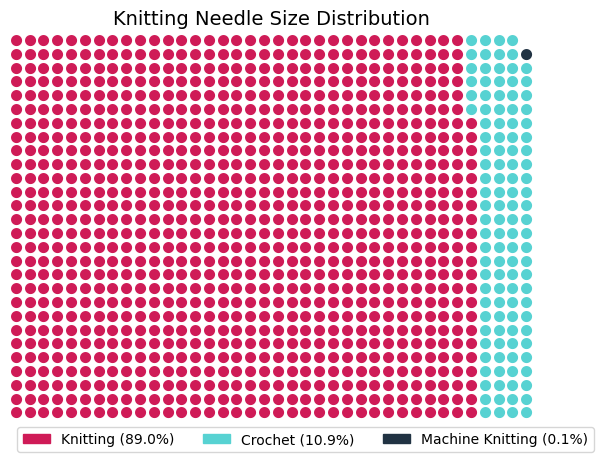

In [17]:
# pywaffle documentation https://pywaffle.readthedocs.io/en/latest/index.html
# tried to make this look like "yarn" and there are ways to use icons or emojis with pywaffle
# but not within google collab.

# Count of patterns by craft
patterns_craft_df = pd.DataFrame(df['craft_name'].value_counts().sort_values())
# Reset the index to ensure correct mapping between values and labels
patterns_craft_df.reset_index(inplace=True)
# Rename the columns for clarity
patterns_craft_df.columns = ['Craft Type', 'Count']
# Sort the DataFrame in descending order
patterns_craft_df.sort_values(by='Count', ascending=False, inplace=True)

#turn into a dictionary
patterns_craft_dict = patterns_craft_df.set_index('Craft Type')['Count'].to_dict()

repartition = [f"{k} ({round(v / sum(patterns_craft_dict.values()) * 100, 1)}%)" for k, v in patterns_craft_dict.items()]

plt.figure(
    FigureClass=Waffle,
    rows=28,
    columns=38,
    values=patterns_craft_dict,
    rounding_rule='floor',
    #characters='◍',
    icons='circle',
    labels=repartition,
    legend={'loc': 'lower left','bbox_to_anchor': (0, -0.11),'ncol': len(patterns_craft_dict)}, # number of columns in the legend
    colors=["#CF1B57", "#57D2D2", "#213343"]
    )

plt.title('Knitting Needle Size Distribution', fontdict={'fontname': 'DejaVu Sans', 'fontsize': 14})

plt.show()

# Also considered a bar chart here, but I liked the waffle
#plt.bar(patterns_craft_df['Craft Type'], patterns_craft_df['Count'])
#plt.xlabel('Craft Type')
#plt.ylabel('Count')
#plt.title('Craft Type Distribution')

#plt.show()

This clearly illustrates that the majority of the top 10,000 patterns on Raverly are knitting patterns (vs. crochet or machine knitting - which is kind of like weaving).

I am only a knitter, so in my analysis I am going to only look at knitting patterns.


In [18]:
# filter to just knitting patterns
knitting_df = df[df['craft_name'] == 'Knitting']

#knitting_df.info() # still almost 9000 patterns

### Free Patterns or Paid Patterns?

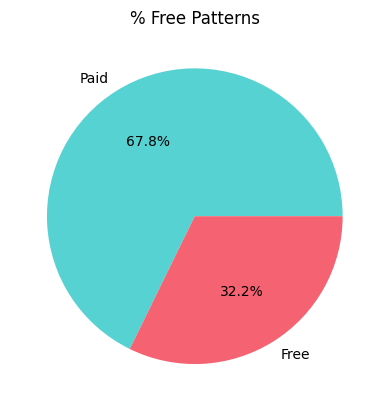

In [19]:
# Count of patterns by free/not free
knitting_free_df = pd.DataFrame(knitting_df['free'].value_counts().sort_values())
# Reset the index to ensure correct mapping between values and labels
knitting_free_df.reset_index(inplace=True)
# Rename the columns for clarity
knitting_free_df.columns = ['Free', 'Count']
# Sort the DataFrame in descending order
knitting_free_df.sort_values(by='Count', ascending=False, inplace=True)

# Create a pie chart
plt.pie(knitting_free_df['Count'], labels=['Paid', 'Free'], colors=['#57D2D2', '#F56271'], autopct='%1.1f%%')
plt.title("% Free Patterns")

# Display the pie chart
plt.show()

Additionally, some patterns on Ravelry are Paid and some are free. In this case, because there are only two variables, it is effective to use a pie chart. We can clearly see that there are more free patterns than paid patterns on Ravelry.

I eventually want to sell knitting patterns, so I am more focused on what types of patterns are patterns that folks will pay for.

To get to that we have to look at the distribution of what item each pattern makes.

In [20]:
knitting_patterns_type_df = knitting_df.groupby('item_type_name').agg({'patt_id': 'nunique', 'projects_count': 'sum','favorites_count': 'sum'})
# Sort the DataFrame by the count of patterns in descending order
knitting_patterns_type_df.sort_values('patt_id', ascending=False, inplace=True)
# Select the top 23 item types with the largest sum of projects_count - this might just exclude 'Naughty'
knitting_patterns_type_df = knitting_patterns_type_df.head(23)

# Reset the index to ensure correct mapping between values and labels
knitting_patterns_type_df.reset_index(inplace=True)
# Rename the columns for clarity
knitting_patterns_type_df.columns = ['Item Type', 'Pattern Count', 'Project Count', 'Favorite Count']

In [21]:
# Filter knitting_df to only include free patterns
free_knitting_df = knitting_df[knitting_df['free'] == True]

# Group by item_type_name and count the patt_ids
free_pattern_count_df = free_knitting_df.groupby('item_type_name')['patt_id'].count().reset_index()

# Rename the columns
free_pattern_count_df.columns = ['Item Type', 'Free Pattern Count']

In [22]:
# Filter knitting_df to only include paid patterns
paid_knitting_df = knitting_df[knitting_df['free'] == False]

# Group by item_type_name and count the patt_ids
paid_pattern_count_df = paid_knitting_df.groupby('item_type_name')['patt_id'].count().reset_index()

# Rename the columns
paid_pattern_count_df.columns = ['Item Type', 'Paid Pattern Count']

In [23]:
# Merge pattern_count_df with knitting_patterns_type_df on 'Item Type'
knitting_patterns_type_df = knitting_patterns_type_df.merge(paid_pattern_count_df, on='Item Type', how='left')
knitting_patterns_type_df = knitting_patterns_type_df.merge(free_pattern_count_df, on='Item Type', how='left')

### What Kinds of Patterns are Popular

Of the top ~8,000 knitting patterns on Ravelry, what is the break down of item type? On top of that, what is the distribution of free and paid patterns.

My hypothesis here is that simpler items (hats, scarfs, shawls) may (1) have more patterns in the top 8000 and (2) have more free patterns compared to other item types. These items are easier to design and knit and may be ways for new pattern designers to get started and/or they are easy enough that folks aren't willing to pay for them.

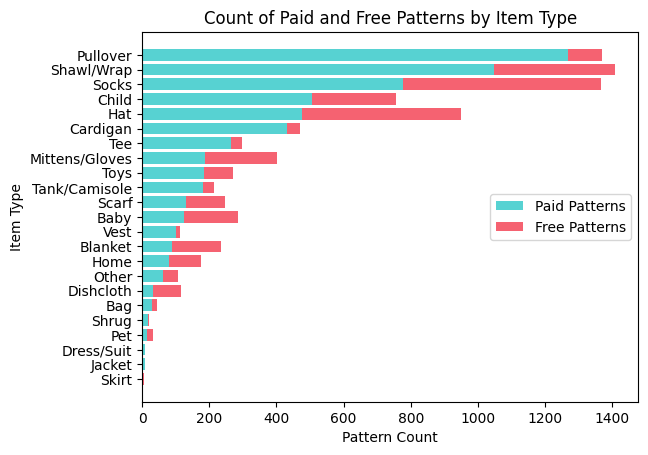

In [24]:
# Sort the DataFrame by the count of paid patterns in descending order
knitting_patterns_type_df = knitting_patterns_type_df.sort_values('Paid Pattern Count', ascending=True)

# matching colors to pie chart where paid = blue and free = red
# Create a horizontal bar plot for paid patterns
plt.barh(knitting_patterns_type_df['Item Type'], knitting_patterns_type_df['Paid Pattern Count'], label='Paid Patterns', color='#57D2D2', )

# Create a horizontal bar plot for free patterns, starting at the end of the paid patterns
plt.barh(knitting_patterns_type_df['Item Type'], knitting_patterns_type_df['Free Pattern Count'], label='Free Patterns', color='#F56271',
         left=knitting_patterns_type_df['Paid Pattern Count'])
# Add labels and title
plt.xlabel('Pattern Count')
plt.ylabel('Item Type')
plt.title('Count of Paid and Free Patterns by Item Type')

# Add legend
plt.legend()

# Display the chart
plt.show()

This was not exactly what I was expecting. I am surprised to see that Pullovers (Sweaters) make up the largest group of patterns in the top 8000 knitting patterns. However, I did expect to see a low number of free Pullover patterns - knitting a sweater is hard!

Socks, Hats, Mittens/Gloves, Baby, and Dishcloths have a pretty even split between free and paid patterns - which indicates that those item types might not not be as lucrative (there is more competition from free patterns).

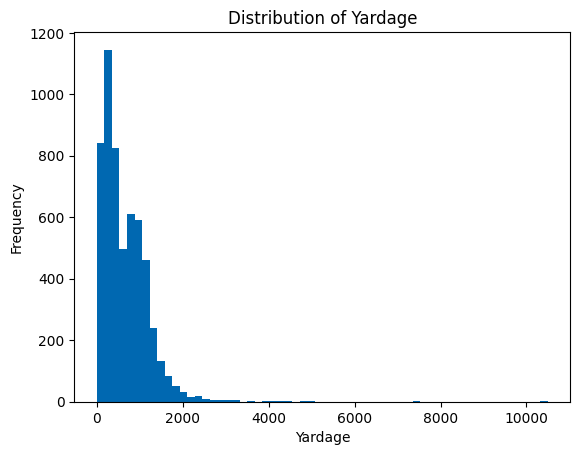

In [25]:
# Create the histogram
plt.hist(paid_knitting_df['yardage'], bins = 60, color='#0068B1')

# Add labels and title to the plot
plt.xlabel('Yardage')
plt.ylabel('Frequency')
plt.title('Distribution of Yardage')

# Display the plot
plt.show()
# definite bias towards lower-yardage projects - understandable, they get done more quickly

It makes sense that lower-yardage patterns make up more of the top patterns on Ravelry. Especially since we have already seen that socks and shawls are very popular pattern types. It may suggest that pattern-buyers prefer shorter, smaller projects that are easier (and potentially more satisfying) to finish.

### What Kinds of Needles & Yarns are Popular?

The next two graphs look at the most popular needle size and yarn type. These should be pretty well-correlated, so for these I really wanted to focus on creating some interesting visuals and stretching what I can do in python.

For the needles I really wanted to make the bar graph look like needles. For the yarn weights I wanted to make the bar graphs look like yarn and (if I could) make the yarns get wider as the yarn weights got bigger.

In [26]:
# Convert the column to categorical type
paid_knitting_df['pattern_needle_size_mm'] = pd.Categorical(paid_knitting_df['pattern_needle_size_mm'], ordered=True)

#group by needle size
knitting_needle_type_df = paid_knitting_df.groupby('pattern_needle_size_mm').agg({'patt_id': 'nunique'})

# Reset the index to ensure correct mapping between values and labels
knitting_needle_type_df.reset_index(inplace=True)

# Rename the columns for clarity
knitting_needle_type_df.columns = ['Needle Size', 'Count']

# knitting needle order
order = ['1.75', '2.0', '2.25', '2.5', '2.75', '3.0', '3.25', '3.5', '3.75', '4.0', '4.5', '5.0', '5.5', '6.0', '6.5', '7.0', '8.0', '9.0', '10.0', '12.0', '15.0']

# reorder data frame
knitting_needle_type_df['Needle Size'] = knitting_needle_type_df['Needle Size'].cat.reorder_categories(order)
knitting_needle_type_df = knitting_needle_type_df.sort_values('Needle Size')

# doubling checking
#knitting_needle_type_df

<ipython-input-26-fd61e73ebff9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  paid_knitting_df['pattern_needle_size_mm'] = pd.Categorical(paid_knitting_df['pattern_needle_size_mm'], ordered=True)


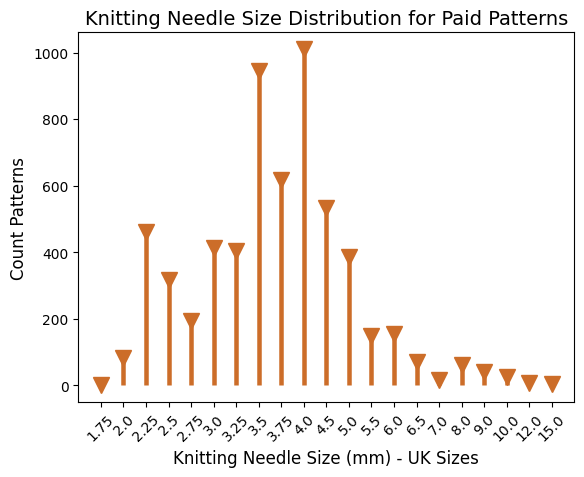

In [27]:
# trying to turn lollipop chart into knitting needles
# this is an interesting syntax - found on https://python-graph-gallery.com/181-custom-lollipop-plot/

(markers, stemlines, baseline) = plt.stem(knitting_needle_type_df['Needle Size'], knitting_needle_type_df['Count'], markerfmt=' ')
plt.setp(markers, marker='v', markersize=11, color='#CC6D29') # making the lollipop an upsidedown triangle
plt.setp(baseline, visible=False)
plt.setp(stemlines, linestyle="-", color='#CC6D29', linewidth=3.25) # changing color, thickness of line

# font options I like: 'DejaVu Sans''cmss10'('fontweight': 'bold')
plt.xlabel('Knitting Needle Size (mm) - UK Sizes', fontdict={'fontname': 'DejaVu Sans', 'fontsize': 12})
plt.ylabel('Count Patterns', fontdict={'fontname': 'DejaVu Sans', 'fontsize': 12})
plt.title('Knitting Needle Size Distribution for Paid Patterns', fontdict={'fontname': 'DejaVu Sans', 'fontsize': 14})

plt.xticks(knitting_needle_type_df['Needle Size'])
plt.xticks(rotation=45)

# Code to make it horizonal
# After comparing I decided I like the vertical better although the horizonal might look more like needles.
#needle_sizes = knitting_needle_type_df['Needle Size']
#count_patterns = knitting_needle_type_df['Count']

# Create horizontal lollipop chart
#fig, ax = plt.subplots()
#ax.hlines(needle_sizes, 0, count_patterns, color='#CC6D29', linewidth=3.25)
#ax.scatter(count_patterns, needle_sizes, marker='<', s=100, color='#CC6D29')

# Set plot properties
#plt.xlabel('Count Patterns', fontdict={'fontname': 'DejaVu Sans', 'fontsize': 12})
#plt.ylabel('Knitting Needle Size (mm) - UK Sizes', fontdict={'fontname': 'DejaVu Sans', 'fontsize': 12})
#plt.title('Knitting Needle Size Distribution', fontdict={'fontname': 'DejaVu Sans', 'fontsize': 14})
#plt.xticks(rotation=45)

# Display the plot
#plt.show()

plt.show()

In [28]:
# Convert the column to categorical type
paid_knitting_df['yarn_weight_name'] = pd.Categorical(paid_knitting_df['yarn_weight_name'], ordered=True)

#group by yarn weight
paid_yarn_weight_df = paid_knitting_df.groupby('yarn_weight_name').agg({'patt_id': 'nunique'})

# Reset the index to ensure correct mapping between values and labels
paid_yarn_weight_df.reset_index(inplace=True)

# Rename the columns for clarity
paid_yarn_weight_df.columns = ['Yarn Weight', 'Count']

# yarn weight order
order = ['Thread', 'Lace', 'Fingering', 'Light Fingering', 'Sport', 'DK', 'Worsted', 'Aran / Worsted','Aran', 'Bulky', 'Super Bulky', 'Jumbo' , 'Any gauge']

# reorder data frame
paid_yarn_weight_df['Yarn Weight'] = paid_yarn_weight_df['Yarn Weight'].cat.reorder_categories(order)
paid_yarn_weight_df = paid_yarn_weight_df.sort_values('Yarn Weight')

# filter out any one with < 5 yarns
paid_yarn_weight_df = paid_yarn_weight_df[paid_yarn_weight_df['Count'] > 5]
# filter out any gauge
paid_yarn_weight_df = paid_yarn_weight_df[paid_yarn_weight_df['Yarn Weight'] != 'Any gauge']

#paid_yarn_weight_df

<ipython-input-28-24fbbe7218a4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  paid_knitting_df['yarn_weight_name'] = pd.Categorical(paid_knitting_df['yarn_weight_name'], ordered=True)


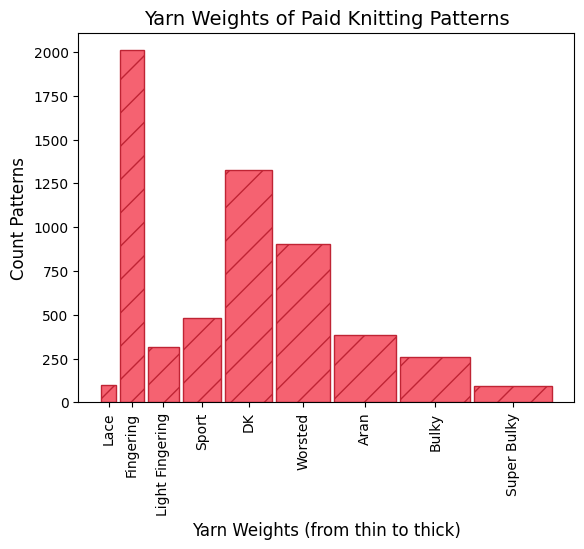

In [29]:
# Create a figure and axis
fig, ax = plt.subplots()

width = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
x_pos = np.cumsum(width) - 0.5 * np.sum(width[:len(paid_yarn_weight_df)])
plt.bar(x_pos, paid_yarn_weight_df['Count'], hatch='/', width=width, color='#F56271', edgecolor='#BF2434')

# Set the tick locations and labels
plt.xticks(x_pos, paid_yarn_weight_df['Yarn Weight'], rotation=90)
ax.set_xticks(x_pos)

# Set the axis labels and title
plt.xlabel('Yarn Weights (from thin to thick)', fontdict={'fontname': 'DejaVu Sans', 'fontsize': 12})
plt.ylabel('Count Patterns', fontdict={'fontname': 'DejaVu Sans', 'fontsize': 12})
plt.title('Yarn Weights of Paid Knitting Patterns', fontdict={'fontname': 'DejaVu Sans', 'fontsize': 14})

# Show the graphic
plt.show()

Interestingly, the yarns weight and needle size don't tell exactly the same story. The recommended knitting needle size for Fingering (the most popular yarn weight) is 3mm and we see that the most popular knitting needles are between 3.5-4. This suggest that potentially some of these patterns (perhaps the shawls) call for slightly looser gauges than standard.

As an aside - it was really fun to create these visuals that look like knitting needles and yarn respectively.

### How are the Patterns Advertised?

Similar to most social sites (think Instagram or LinkedIn), SEO (Search Engine Optimization) may play a role in the popularity of the patterns.

On Ravelry, these are called "attributes" and they're kinda like tags that get attached to the patterns. Sometimes they are keywords, but they can also describe the way a pattern is knit (for example, "ragalan" or "in the round").

I am curious about a few things: is it important how many tags are attached to a pattern? and what sort of attributes seem to be the most common?

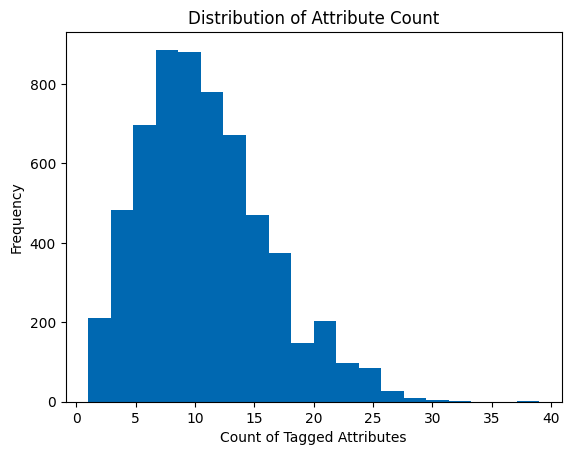

In [30]:
# Create the histogram
plt.hist(paid_knitting_df['count_pattern_attributes'], bins = 20, color='#0068B1')

# Add labels and title to the plot
plt.xlabel('Count of Tagged Attributes')
plt.ylabel('Frequency')
plt.title('Distribution of Attribute Count')

# Display the plot
plt.show()

It seems like there is a good distribution of pattern attributes from 1 or 2 to almost 40.


Next, I wanted to look at what those attributes _are_. Attributes are inherently a little bit messy (since it is a tagging process) so I sort of wanted my visual to reflect the chaos. I went with a word cloud (to again experiment with different visualization options).

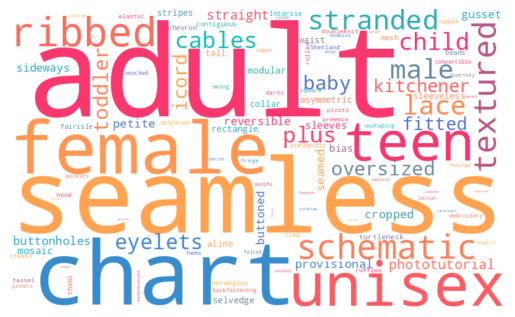

In [31]:
# Extract words after 'permalink'
words = []
for row in paid_knitting_df['pattern_attributes']:
    matches = re.findall("'permalink': '(\w+)'", row)
    words.extend(matches)

# Create a string from the extracted words
wordcloud_string = " ".join(words)

# Count the frequency of each word
word_count = Counter(words)

# Create a list of unique words with their corresponding frequencies
unique_words = [(word, count) for word, count in word_count.items()]

# Define custom colormap
colors = [(0, '#5C62D6'), (0.25, '#0FBFBF'), (0.5, '#F62D71'), (0.75, '#FF7A59'), (1, '#FFBC4B')]
cmap_name = 'custom_colormap'
cmap = LinearSegmentedColormap.from_list(cmap_name, colors)

# Create the wordcloud object
wordcloud = WordCloud(width=800, height=480, margin=0, background_color='white', relative_scaling=0.5,
                      colormap=cmap).generate_from_frequencies(dict(unique_words))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

I actually think this word cloud is really helpful. It definitely makes sense to me that most of the patterns are geared toward adult women (that definitely makes up most of the knitting population). I know that when I have looked for patterns to make for men in the past, there are not a lot.

There are some things here that are really helpful for a wannabe pattern designer. For example, I can easily see that seamless designs make up a lot of the top paid patterns and that it seems like having a chart (diagram of the pattern) is really popular. These are definitely thinks I could take into my pattern designers.

### How Do Patterns Cost?

The last thing I want to look at for this visualization/analysis is the distribution of prices for patterns. There are tons of patterns that don't list their prices in USD, so I filtered those out to just look at USDs.

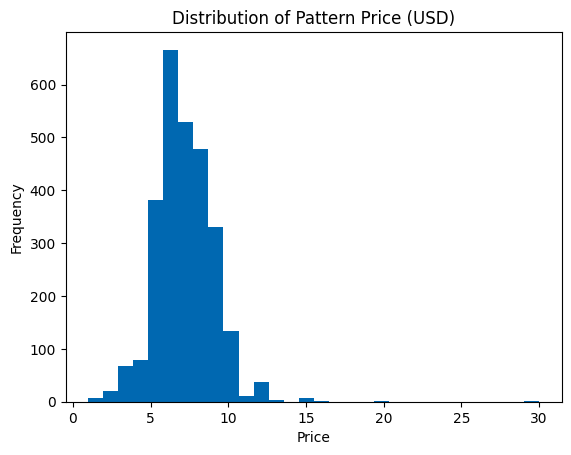

In [32]:
# filter to just knitting patterns sold in usd
usd_paid_knitting_df = paid_knitting_df[paid_knitting_df['currency'] == 'USD']

# Create the histogram
plt.hist(usd_paid_knitting_df['price'], bins=30, color='#0068B1')

# Add labels and title to the plot
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Distribution of Pattern Price (USD)')

# Display the plot
plt.show()
# tends somewhat to the right; not unexpected, this measure is subjective and people tend to think something
# they can do is lower on the difficulty scale

Consistent with what I have seen on Ravelry, most patterns cost between $5 and $10. I might havce to go back and look at what pattern could possibly cost $30.

## Analysis

My focus for this project was definitely more on data cleaning and visualization, so this section is a bit lighter. However, I think I can answer some analytic questions that will help me understand what types of patterns are the most lucrative.

### Are some Pattern Types more "Favorited" than Created?

One of the things I wanted to look at quickly (below) is the conversion rate from "favorting" a pattern to actually having a project attached to it. I suspect that there are a lot of really beautiful photos of items on ravelry that folks might THINK they want to make but never actually do. This is interesting for me to look at because I'd want people to actually buy my patterns, not just "favorite" them.

In [33]:
# looking only at paid patterns below
paid_knitting_patterns_type_df = paid_knitting_df.groupby('item_type_name').agg({'patt_id': 'nunique', 'projects_count': 'sum','favorites_count': 'sum'})
# Sort the DataFrame by the count of patterns in descending order
paid_knitting_patterns_type_df.sort_values('patt_id', ascending=False, inplace=True)
# Select the top 23 item types with the largest sum of projects_count - this might just exclude 'Naughty'
paid_knitting_patterns_type_df = paid_knitting_patterns_type_df.head(23)

# Reset the index to ensure correct mapping between values and labels
paid_knitting_patterns_type_df.reset_index(inplace=True)
# Rename the columns for clarity
paid_knitting_patterns_type_df.columns = ['Item Type', 'Pattern Count', 'Project Count', 'Favorite Count']

# Create the calculated column 'Favorites to Projects Ratio'
paid_knitting_patterns_type_df['Favorites to Projects Conversion'] =  paid_knitting_patterns_type_df['Project Count'] / paid_knitting_patterns_type_df['Favorite Count']

# Sort the dataframe by 'Favorites to Projects Ratio' column in descending order
paid_knitting_patterns_type_df = paid_knitting_patterns_type_df.sort_values('Favorites to Projects Conversion', ascending=False)

# Print the updated dataframe
paid_knitting_patterns_type_df

<ipython-input-33-e4d389ed75c0>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  paid_knitting_patterns_type_df['Favorites to Projects Conversion'] =  paid_knitting_patterns_type_df['Project Count'] / paid_knitting_patterns_type_df['Favorite Count']


,Item Type,Pattern Count,Project Count,Favorite Count,Favorites to Projects Conversion
2,Socks,777,374165,1486590,0.251693
15,Other,62,70251,283442,0.247850
10,Scarf,131,135513,582455,0.232658
11,Baby,126,106052,530498,0.199910
16,Dishcloth,32,12569,65522,0.191829
8,Toys,184,122118,699286,0.174632
3,Child,507,357206,2297234,0.155494
14,Home,80,27139,190426,0.142517
4,Hat,476,211126,1623608,0.130035
19,Pet,15,5895,47575,0.123910


I feel like this intuitively makes A LOT of sense to me (especially the bottom of the list). The smaller, quicker projects are more likely to be favorited AND actioned. On the other side, the Pullovers have THE MOST favorites, but definitely not as many actual projects because it is a bigger project to commit to.

### A Quick Linear Regression

I admittedly spent much more time on the visualizations than any sort of modeling. However, I am curious if I can figure out how Raverlry creates its ranking of popularity.

For this I went back to the full data set:

In [34]:
# Drop rows with null values
linear_df = df.dropna()

# Separate the independent variables from the dependent variable
# I am guessing waht I think might be the most impactful
X = linear_df[['projects_count', 'favorites_count', 'count_pattern_attributes','pattern_author_pattern_count']]
y = linear_df['pattern_rank']

# Create an instance of the Linear Regression model
model = LinearRegression()

# Fit the model using X and y
model.fit(X, y)

# Create a DataFrame to display the results
results_df = pd.DataFrame({'Variable': X.columns, 'Coefficient': model.coef_})

# Create a DataFrame for the intercept
intercept_df = pd.DataFrame({'Variable': ['Intercept'], 'Coefficient': [model.intercept_]})

# Concatenate the results DataFrame and intercept DataFrame
results_df = pd.concat([results_df, intercept_df], ignore_index=True)

# Print the results DataFrame
results_df

,Variable,Coefficient
0,projects_count,-0.098565
1,favorites_count,-0.161657
2,count_pattern_attributes,63.974818
3,pattern_author_pattern_count,-0.181500
4,Intercept,4888.851334


Without getting into statistical significance:
* For each unit increase in `projects_count`, the `pattern_rank` decreases by approximately 0.099.

* For each unit increase in `favorites_count` variable, `pattern_rank` is expected to decrease by 0.16 units.

* For each unit increase in `count_pattern_attributes` variable, `pattern_rank` is expected to increase by 63.8.

* For each unit increase in `pattern_author_pattern_count` variable, `pattern_rank` is expected to decrease by 0.18.

It makes sense that the more projects and favorites are associated with a pattern the higher it falls in the popularity ranking (I'd expect the ranking based on projects or favorites). It also tracks that a higher rank would be positively correlated to more prolific authors.

One thing that is unexpected is that it seems like pattern_attribute_count is negatively correlated to pattern_rank. This might be that newer designers (who are less popular) are more likely to try to use a lot of tags to increase searchabilty while more established designers rely on their brand.


# Final Thoughts: What sort of Pattern should I Design?

There were a lot of directions that I could have taken this analysis given the amount of data I was able to get via the API. I chose to focus on data around the most popular patterns on Raverly's homepage with the goal of coming up with a recommended pattern for me to design and sell.

There were a few takaways in terms of recommendations:

* Steer clear of really chunky yarn or needles - thinner yarn and needles make up most of the popular projects. Specifically focusing on Fingering or DK weight and size 4mm needles.
* Raverly users love Pullovers and Socks, but are probably more likely to make a sock pattern (guess its time to learn how to make socks)!
* I should sell my pattern for ~6 dollars
* Many of the popular patterns are geared toward adult women - I could either try to differentiate (and do men) or focus on that population.
* Seamless pattens with a chart seem like attributes that folks are interested in.
* More Attributes is not better.


Finally, it does seem like more extablished designers have a bit of a leg up. One thing I'd like to explore as a next analysis is to dig into the data on the designers themselves to understand who they are (and where they are located).